In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import pickle
import pylab
import numpy as np
import scipy
import torch.optim as optim
import pandas as pd
import torchvision.datasets as datasets
import time
import tensorflow as tf
import alibi


from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler

from scipy.spatial.distance import euclidean
from scipy.stats import shapiro, normaltest

from torchvision import transforms
from torchvision.utils import save_image

from collections import Counter

from copy import deepcopy

from torch.autograd import Variable

from skimage.io import imread

# Local imports
from local_models import *
from helper_functions import *
from piece_hurdle_model import *
from optimize_explanations import *
from evaluation_metrics import *

#new lib
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import accuracy_score
from itertools import combinations
from sklearn.model_selection import train_test_split
from IPython.display import Image

In [3]:
# Load models and data
G, cnn = load_models(CNN, Generator)
# classifierCNN = ClassifierCNN(cnn)
# croppedCNN = CroppedCNN(cnn)
train_loader, test_loader = load_dataloaders()
X_train, y_train, X_test, y_test = get_MNIST_data(datasets)

expt1_data = pd.DataFrame(columns=['rand_num', 'name', 'MC-Mean', 'MC-STD', 'NN-Dist', 'IM1', 'IM2', 'optim_time'])

df_piece = pd.DataFrame(columns=['rand_num', 'name', 'MC-Mean', 'MC-STD', 'NN-Dist', 'IM1', 'IM2', 'optim_time'])
df_ME = pd.DataFrame(columns=['rand_num', 'name', 'MC-Mean', 'MC-STD', 'NN-Dist', 'IM1', 'IM2', 'optim_time'])
df_CME = pd.DataFrame(columns=['rand_num', 'name', 'MC-Mean', 'MC-STD', 'NN-Dist', 'IM1', 'IM2', 'optim_time'])


In [4]:


# k-NN for NN-Dist
X_train_act = np.load("data/distribution_data/X_train_act.npy")
X_test_act = np.load("data/distribution_data/X_test_act.npy")
X_train_pred = np.load("data/distribution_data/X_train_pred.npy")
X_test_pred = np.load("data/distribution_data/X_test_pred.npy")
k_nn = KNeighborsClassifier(n_neighbors=1, algorithm='brute')
k_nn.fit(X_train_act, X_train_pred)

KNeighborsClassifier(algorithm='brute', n_neighbors=1)

In [5]:
# Loading AEs for IM1 and IM2 metrics
aes, ae_full = load_autoencoders()


Probabilitiy threshold for identifying "Exceptional Features" with PIECE



Control the number of anomalous features that need to be changed by a.

In [6]:
# Probabilitiy threshold for identifying "Exceptional Features" with PIECE
alpha = 0.05

Run a counterfactual algorithm based on images that have been misclassified.

Label: 4
Prediction: 6


c:\Users\13478\Desktop\AAAI-2021-master\AAAI-2021-master\helper_functions.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['flag'] = np.zeros(df.shape[0])


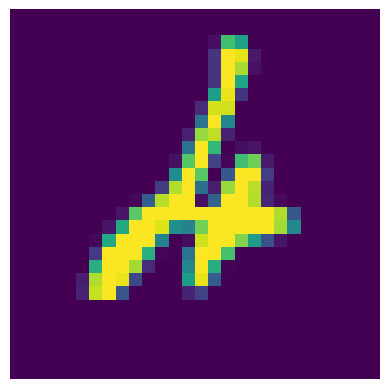

In [7]:
# Iterate though 41 Incorrect examples from MNIST
for rand_num in range(1,42):

	# Get Query representations
	original_query_idx, original_query_img, target_class = get_missclassificaiton(test_loader, cnn, rand_num)
	original_query_pred = int(torch.argmax(cnn(original_query_img)[0]))
	z = torch.load("data/latent_g_input_saved/incorrect_latent/misclassify_" + str(rand_num) + ".pt") 
	query_activations = cnn(G(z))[1][0]

	#### ========== First two steps of PIECE Algorithm ========== ####
	# Step 1: Acquire the probability of each features, and identify the excpetional ones (i.e., those with a probability lower than alpha)
	df = acquire_feature_probabilities(target_class, cnn, original_query_img, alpha) 
	# Step 2: Filter out exceptional features which we want to change, and change them to their expected values in the counterfactual class
	df = filter_df_of_exceptional_noise(df, target_class, cnn, alpha)
	# Sort by least probable to the most probable
	df = df.sort_values('Probability of Event')
	# Get x' -- The Ideal Explanation
	ideal_xp = modifying_exceptional_features(df, target_class, query_activations)   
	ideal_xp = ideal_xp.clone().detach().float().requires_grad_(False)

	save_paths = {
		'PIECE': 'data/PIECE/a1/',
		'Min-Edit': 'data/Min-Edit/',
		'C-Min-Edit': 'data/C-Min-Edit/'
	}

	# For Save z.pt
	for algorithm, path in save_paths.items():
		os.makedirs(path, exist_ok=True)


	for name in ['PIECE', 'Min-Edit', 'C-Min-Edit']:  # 'CEM', 'Proto-CF']:

		# print(" ")
		# print("-------------------------------")
		# print(rand_num, name)
		# print("-------------------------------")

		cnn = cnn.eval()
		temp_data = pd.DataFrame(columns=['rand_num', 'name', 'MC-Mean', 'MC-STD', 'NN-Dist', 'IM1', 'IM2', 'optim_time'])

		# Query
		x_q = cnn(G(z))[1][0]

		# Explanation latent input (to optimize...)
		z_e = z.clone().detach().float().requires_grad_()

		criterion = nn.MSELoss()

		start_time = time.time()

		if name == 'PIECE':
			optimizer = optim.Adam([z_e], lr=0.01)
			z_e = optim_PIECE(G, cnn, ideal_xp, z_e, criterion, optimizer)

		elif name == 'Min-Edit':
			optimizer = optim.Adam([z_e], lr=0.001)
			z_e = optim_min_edit(cnn, G, z_e, optimizer, target_class)

		elif name == 'C-Min-Edit':
			optimizer = optim.Adam([z_e], lr=0.001)
			z_e = optim_c_min_edit(G, cnn, x_q, z_e, criterion, optimizer, target_class)

		elif name == 'CEM':
			xp = optim_CEM_Explanation(original_query_idx)
			try:
				if xp == None:
					print("Couldn't Find Explanation")
					continue
			except:
				print('Found Explanation')

		elif name == 'Proto-CF':
			xp = optim_Proto_Explanation(original_query_idx)
			try:
				if xp == None:
					print("Couldn't Find Explanation")
					continue
			except:
				print('Found Explanation')
		torch.save(z_e, os.path.join(save_paths[name], f'z_e_{rand_num}.pt'))

		optim_time = time.time() - start_time

		if name == 'PIECE' or name == 'Min-Edit' or name == 'C-Min-Edit':
			I_e = G(z_e)
			
		elif name == 'CEM' or name == 'Proto-CF':
			I_e = torch.tensor(xp, dtype=torch.float32).reshape(-1,1,28,28)

		save_name = name
		save_query_and_gan_xp_for_final_data(I_e, cnn, z, G, z_e, original_query_img, save_name, rand_num, target_class, original_query_pred)
		
		
		# New prediction of explanation
		new_pred = int(torch.argmax(torch.exp(  cnn(I_e)[0]  )))
		
		# Metrics for Plausibility
		mc_dropout_results = mc_dropout(cnn, new_pred, I_e)
		nn_dist, _ = k_nn.kneighbors(X=np.array(    cnn(I_e)[1].detach().numpy()  )  , n_neighbors=2)
		IM1 = IM1_metric(I_e, aes, original_query_pred, new_pred)
		IM2 = IM2_metric(I_e, aes, ae_full, new_pred)
		
	
		temp_data = pd.Series({
			'rand_num': rand_num,
			'name': name,
			'MC-Mean': mc_dropout_results.mean(),
			'MC-STD': mc_dropout_results.std(),
			'NN-Dist': nn_dist[0][0],
			'IM1': IM1,
			'IM2': IM2,
			'optim_time': optim_time
		})

		# record save as csv
		expt1_data = pd.concat([expt1_data, temp_data.to_frame().T], ignore_index=True) 
		if name == 'PIECE':
			df_piece = pd.concat([df_piece, temp_data.to_frame().T], ignore_index=True) 
		elif name == 'Min-Edit':
			df_ME = pd.concat([df_ME, temp_data.to_frame().T], ignore_index=True) 
		elif name == 'C-Min-Edit':
			df_CME = pd.concat([df_CME, temp_data.to_frame().T], ignore_index=True)
		

In [10]:
expt1_data.to_csv('ablation1.csv', index=False)

df_piece.to_csv('df_piece.csv', index=False)
df_ME.to_csv('df_ME.csv', index=False)
df_CME.to_csv('df_CME.csv', index=False)
	


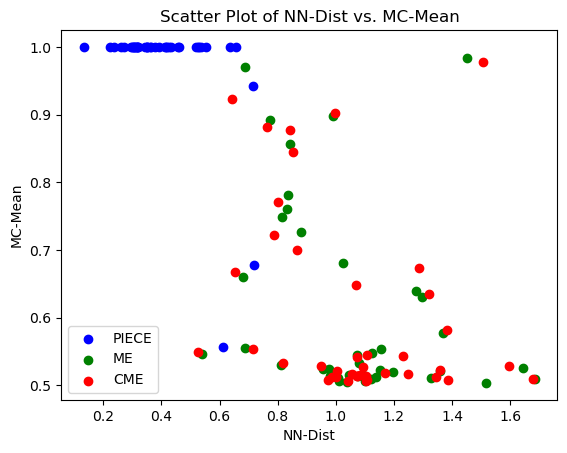

In [14]:
data_frame1 = pd.read_csv('mnist_record/a5/df_piece.csv')
data_frame2 = pd.read_csv('mnist_record/a5/df_ME.csv')
data_frame3 = pd.read_csv('mnist_record/a5/df_CME.csv')


x1 = data_frame1['NN-Dist']
y1 = data_frame1['MC-Mean']/1000


x2 = data_frame2['NN-Dist']
y2 = data_frame2['MC-Mean']/1000


x3 = data_frame3['NN-Dist']
y3 = data_frame3['MC-Mean']/1000


y1_tensor = torch.tensor(y1)
y2_tensor = torch.tensor(y2)
y3_tensor = torch.tensor(y3)


y1_sigmoid = torch.sigmoid(y1_tensor)
y2_sigmoid = torch.sigmoid(y2_tensor)
y3_sigmoid = torch.sigmoid(y3_tensor)


y1_final = y1_sigmoid.detach().numpy()
y2_final = y2_sigmoid.detach().numpy()
y3_final = y3_sigmoid.detach().numpy()

plt.scatter(x1, y1_final, color='blue', label='PIECE')
plt.scatter(x2, y2_final, color='green', label='ME')
plt.scatter(x3, y3_final, color='red', label='CME')


plt.legend()
plt.xlabel('NN-Dist')
plt.ylabel('MC-Mean')
plt.title('Scatter Plot of NN-Dist vs. MC-Mean')
plt.savefig('Scatter Plot of NN-Dist vs. MC-Mean.png')

plt.show()

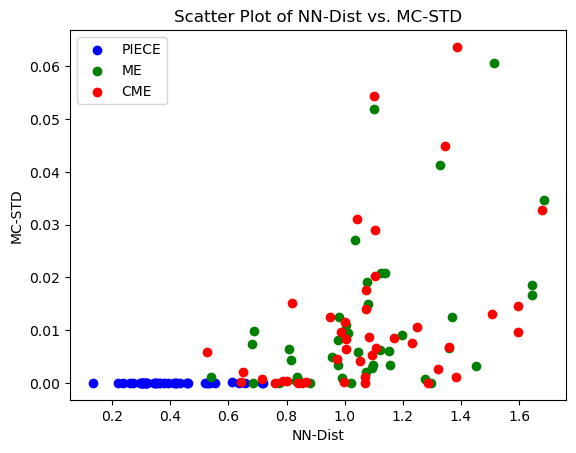

In [15]:
data_frame1 = pd.read_csv('mnist_record/csv/df_piece.csv')
data_frame2 = pd.read_csv('mnist_record/csv/df_ME.csv')
data_frame3 = pd.read_csv('mnist_record/csv/df_CME.csv')

# 提取数据
x1 = data_frame1['NN-Dist']
y1 = data_frame1['MC-STD']

x2 = data_frame2['NN-Dist']
y2 = data_frame2['MC-STD']

x3 = data_frame3['NN-Dist']
y3 = data_frame3['MC-STD']

# 绘制点图
plt.scatter(x1, y1, color='blue', label='PIECE')
plt.scatter(x2, y2, color='green', label='ME')
plt.scatter(x3, y3, color='red', label='CME')

# 添加图例和标签
plt.legend()
plt.xlabel('NN-Dist')
plt.ylabel('MC-STD')
plt.title('Scatter Plot of NN-Dist vs. MC-STD')
plt.savefig('Scatter Plot of NN-Dist vs.  MC-STD.png')
# 显示图形
plt.show()

New Evalution :main idea of one-Nearest Neighbor Classifier

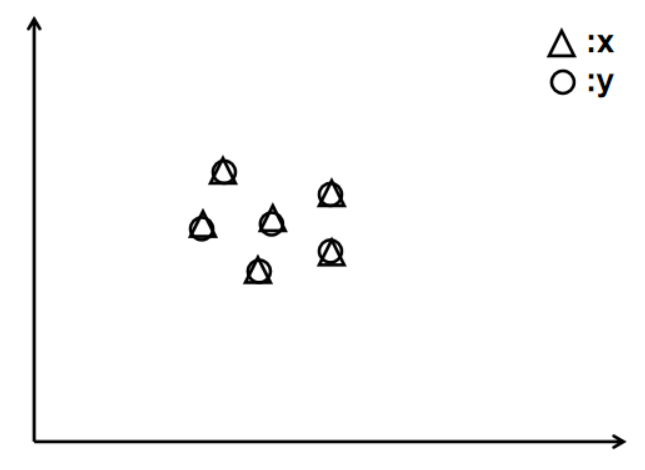

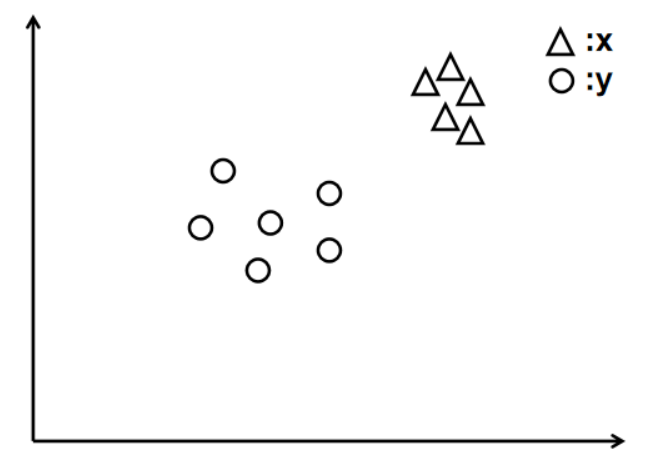

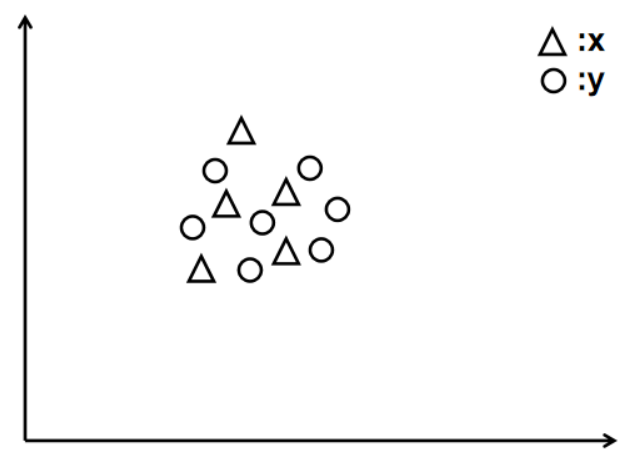

In [16]:
display(Image("imgs/overfitting.png", width=200))
display(Image("imgs/classifiy.png", width=200))
display(Image("imgs/missclassify.png", width=200))

Training a knn classifier, the closer to 50% means that the classifier cannot distinguish the generated counterfactual image from the original.

In [14]:


def generator_Classifier():
    """
    one-Nearest Neighbor Classifier
    Determine how close the modified image is to the original.
    When the accuracy approaches 50%, it indicates that the distance between generated and real samples is close, without being caused by overfitting.
    """
    # Get all .pt file paths in the folders
    file_paths_folder1 = glob.glob("data/latent_g_input_saved/incorrect_latent/*.pt")
    file_paths_folder2 = glob.glob("data/latent_g_input_saved/correct_latent/*.pt")
    file_paths_folder3 = glob.glob("data/latent_g_input_saved/PIECE/*.pt")
    #file_paths_folder3 = glob.glob("data/latent_g_input_saved/Min-Edit/*.pt")
    #file_paths_folder3 = glob.glob("data/latent_g_input_saved/C-Min-Edit/*.pt")

    
    all_file_paths = file_paths_folder1 + file_paths_folder2

    
    images = []
    labels = []

    # Loop through each file path
    for file_path in all_file_paths:
        
        z = torch.load(file_path) 
        image = G(z)
        images.append(image)
        labels.append(torch.tensor(1))  
    
    for file_path in file_paths_folder3:
        
        z = torch.load(file_path)
        image = G(z)
        images.append(image)
        labels.append(torch.tensor(0))  
    
    D = list(zip(images, labels))

     # Initialize KNN classifier
    knn = KNeighborsClassifier(n_neighbors=1)

    accuracies = []

    # Leave-one-out cross-validation
    for i in range(len(D)):
        # Remove the ith sample from the dataset as the test sample
        D_train = D[:i] + D[i+1:]
        D_test = [D[i]]

        X_train, y_train = zip(*D_train)
        X_test, y_test = zip(*D_test)

        X_train_np = [x.detach().numpy().flatten() for x in X_train]
        y_train_np = [y.detach().numpy().flatten() for y in y_train]
        X_train_flat = [x.flatten() for x in X_train]
        X_test_flat = [x.detach().numpy().flatten() for x in X_test]
        y_test_flat = [y.detach().numpy().flatten() for y in y_test]
        
        knn.fit(X_train_np, y_train_np)
        
        # Classify the test sample
        y_pred = knn.predict(X_test_flat)

        
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    
    mean_accuracy = sum(accuracies) / len(accuracies)

    
    print("Mean Accuracy:", mean_accuracy)

    return mean_accuracy

generator_Classifier()


c:\anaconda\envs\IML\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\anaconda\envs\IML\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\anaconda\envs\IML\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\anaconda\envs\IML\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

Mean Accuracy: 0.4225352112676056


c:\anaconda\envs\IML\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\anaconda\envs\IML\lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.4225352112676056